In [ ]:
from scipy.stats import truncnorm
import pandas as pd
import numpy as np
import itertools
import datetime
import tqdm
import sys
import os

def flatten_list(list_array):
    return list(itertools.chain(*list_array))

sys.path.insert(0, "../")

from global_config import config

results_dir           = config.get_property('results_dir')
results2_dir          = config.get_property('results2_dir')
data_dir              = config.get_property('data_dir')
paper_dir             = config.get_property('paper_dir')
data_db_dir           = config.get_property('data_db_dir')

feb_hosp_records_path = os.path.join(data_db_dir, 'long_files_8_25_2021')
path_to_save          = os.path.join(results_dir, "real_testing", "community")
COLOR_LIST1           = ["#F8AFA8", "#FDDDA0", "#F5CDB4", "#74A089"]

In [ ]:

def capitalize_string_df(df_cap, col_cap):
    df_cap[col_cap] = df_cap[col_cap].map(lambda x: ' '.join([w.lower().capitalize() for w in str(x).split(' ')] ) )
    return df_cap


In [ ]:
dates_simulation = pd.date_range(start="2020-02-01", end="2021-02-28", freq="D")

movement_df                  = pd.read_csv(os.path.join(data_db_dir, "long_files_8_25_2021", 'patient_movement_2022-Nov.csv'), parse_dates=['date']).drop_duplicates(subset=["date", "mrn"], keep="first")
movement_df["ward_total"]    = movement_df.apply(lambda x: x["ward"]+"-"+x["building"]+"-"+x["place"], axis=1)
movement_df                  = movement_df[movement_df["date"].isin(dates_simulation)]

mrd2id                       = {mrn: id for id, mrn in enumerate(movement_df.mrn.unique())}
ward2id                      = {ward_name: id for id, ward_name in enumerate(np.sort(movement_df.ward_total.unique()))}

movement_df["mrn_id"]        = movement_df.mrn.map(mrd2id)
movement_df["ward_id"]       = movement_df.ward_total.map(ward2id)

ward_size_df                 = movement_df.reset_index()
ward_size_df["ward_id"]      = ward_size_df["ward_total"].apply(lambda x: ward2id[x])
ward_size_df["num_patients"] = 1
ward_size_df                 = ward_size_df.groupby(["date", "ward", "ward_id"]).sum()[["num_patients"]].reset_index().drop(columns=["date"])
ward_size_df                 = ward_size_df.groupby(["ward", "ward_id"]).mean().reset_index().sort_values(by="num_patients")
ward2size                    = {r.ward_id: r.num_patients for idx_r, r in ward_size_df.iterrows()}

id2ward                      = dict((v, k) for k, v in ward2id.items())

###-###-###-###-###-###-###-###-###-###-###-###

selected_buildings = ['Allen Hospital-Allen', 'Harkness Pavilion-Columbia',
                        'Milstein Hospital-Columbia', 'Mschony-Chony',
                        'Presbyterian Hospital-Columbia']
selected_buildings2 = ['Allen Hospital', 'Harkness Pavilion',
                        'Milstein Hospital', 'Mschony',
                        'Presbyterian Hospital']

building2id        = {selected_buildings[i]: i for i in range(len(selected_buildings))}
building2id2       = {selected_buildings2[i]: i for i in range(len(selected_buildings))}

def building2observation(building):
    if building in selected_buildings:
        return building2id[building]
    elif building in selected_buildings2:
        return building2id2[building]
    else:
        return 5

ward_names                   = np.sort(list(movement_df.ward_total.unique()))
ward_names_df                = pd.DataFrame(ward_names, columns=["ward"])
ward_names_df                = pd.DataFrame(ward_names, columns=["ward"])
ward_names_df["building"]    = ward_names_df["ward"].apply(lambda x: "-".join(x.split("-")[1:]))
ward_names_df["building_id"] = ward_names_df["building"].apply(lambda x: building2observation(x) )
ward_names_df["ward_id"]     = ward_names_df.apply(lambda x: np.where(ward_names_df.ward == x.ward)[0][0], axis=1)

###-###-###-###-###-###-###-###-###-###-###-###

/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_12449/2070042135.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ward_size_df                 = ward_size_df.groupby(["date", "ward", "ward_id"]).sum()[["num_patients"]].reset_index().drop(columns=["date"])


In [37]:
test_ward_df                             = movement_df.groupby(["date",  "building", "place", "ward_total"]).sum()[["test"]]
test_per_place_ward_df                   = test_ward_df.reset_index().groupby(["place", "building", "ward_total"]).sum()[["test"]].reset_index()
test_per_place_ward_df["building_id"]    = test_per_place_ward_df["building"].apply(lambda x: building2observation(x) )
test_per_place_ward_df["building_coded"] = test_per_place_ward_df["building_id"].apply(lambda x: "Building " + str(x) )

test_per_building_df = test_per_place_ward_df.groupby(["place", "building_id", "building_coded"]).sum()[["test"]].reset_index()


/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_12449/349967029.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  test_ward_df                             = movement_df.groupby(["date",  "building", "place", "ward_total"]).sum()[["test"]]
/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_12449/349967029.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  test_per_place_ward_df                   = test_ward_df.reset_index().groupby(["place", "building", "ward_total"]).sum()[["test"]].reset_index()
/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_12449/349967029.py:6: FutureWarni

In [45]:
test_per_building_df["place"] = ["Allen", "Chony", "Columbia", "Columbia", "Columbia", "Rest"]
test_per_building_df

,place,building_id,building_coded,test
0,Allen,0,Building 0,8032
1,Chony,3,Building 3,7320
2,Columbia,1,Building 1,1466
3,Columbia,2,Building 2,35795
4,Columbia,4,Building 4,4430
5,Rest,5,Building 5,1419


In [54]:
import pylab

cm          = pylab.get_cmap('gist_ncar')
NUM_COLORS  = test_per_building_df["place"].unique().shape[0]+1
place2color = {place: cm(1.*place_idx/NUM_COLORS) for place_idx, place in enumerate(test_per_building_df.place.unique())}

test_per_building_df["color"]         = test_per_building_df["place"].map(place2color)
test_per_building_df["log_test"]      = np.log(test_per_building_df["test"])

test_per_building_df["number"]        = list(range(len(test_per_building_df)))
test_per_building_df["place_renamed"] = test_per_building_df["place"].map({"Columbia": "Hospital A", "Allen": "Hospital B", "Chony": "Hospital C", "Rest": "Rest"})

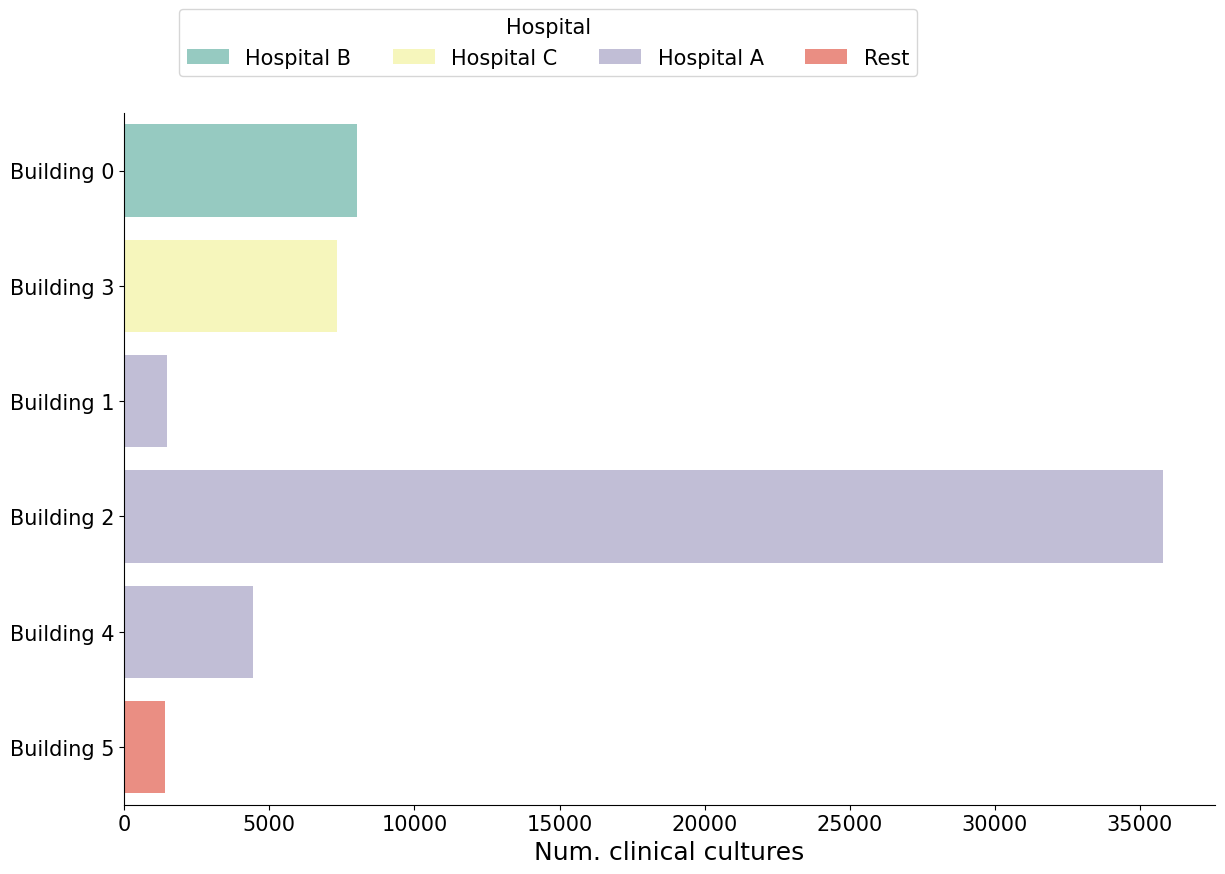

In [69]:
from utils_local import plot_utils
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize=(12.5, 9), sharey=True)

sns.barplot(ax=ax, x="test", y="building_coded", data=test_per_building_df, palette="Set3",  hue="place_renamed", dodge=False)

ax.tick_params(which='both', axis='both')
ax.set_xlabel("Num. clinical cultures")
ax.set_ylabel(None)

#ax.set_xscale("log")

ax.legend(title="Hospital", bbox_to_anchor=(0.05, 1.15), loc=2, borderaxespad=0, ncol=4)
sns.despine(ax=ax, top=True, right=True, left=False, bottom=False)
plt.tight_layout()

path_to_save_fig = os.path.join(results2_dir, "paper_figures", "si_figures")
fig.savefig(os.path.join(path_to_save_fig, "cultuer_per_building_figS12.png"), dpi=300, transparent=True)


In [ ]:
fig     = plt.figure(constrained_layout=True, figsize=(39, 40))
subfigs = fig.subfigures(3, 1, hspace=0.07, wspace=0.1,  height_ratios=[1/3, 1/3, 1/3])

ax1     = subfigs[0].subplots(1, 1)
sns.barplot(ax=ax1, y="num_tests", x="ward_to_plot", data=test_per_place_ward_df[test_per_place_ward_df.place=="Columbia"],
            label="Total", palette=test_per_place_ward_df[test_per_place_ward_df.place=="Columbia"]["color"].values, ci=None)

ax1.set_title("Hospital A")
ax1.tick_params(which='both', axis='both')
ax1.set_ylabel("Log(Num. of cultures)")
ax1.set_yscale('log')
ax1.set_xlabel(None)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)

sns.despine(ax=ax1, top=True, right=True, left=True, bottom=False)
ax1.grid(axis='y', linestyle='-', which='major', color='grey', alpha=.5)
ax1.grid(axis='y', linestyle='--', which='minor', color='grey', alpha=.15)

########################

ax1    = subfigs[1].subplots(1, 1)
sns.barplot(ax=ax1, y="num_tests", x="ward_to_plot", data=test_per_place_ward_df[test_per_place_ward_df.place=="Allen"],
            label="Total", palette=test_per_place_ward_df[test_per_place_ward_df.place=="Allen"]["color"].values, ci=None)

ax1.set_title("Hospital B")
ax1.tick_params(which='both', axis='both')
ax1.set_ylabel("Log(Num. of cultures)")
ax1.set_yscale('log')
ax1.set_xlabel(None)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)

sns.despine(ax=ax1, top=True, right=True, left=True, bottom=False)
ax1.grid(axis='y', linestyle='-', which='major', color='grey', alpha=.5)
ax1.grid(axis='y', linestyle='--', which='minor', color='grey', alpha=.15)

########################

ax1    = subfigs[2].subplots(1, 1)
sns.barplot(ax=ax1, y="num_tests", x="ward_to_plot", data=test_per_place_ward_df[test_per_place_ward_df.place=="Chony"],
            label="Total", palette=test_per_place_ward_df[test_per_place_ward_df.place=="Chony"]["color"].values)

ax1.set_title("Hospital C")
ax1.tick_params(which='both', axis='both')
ax1.set_ylabel("Log(Num. of cultures)")
ax1.set_yscale('log')
ax1.set_xlabel(None)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)

sns.despine(ax=ax1, top=True, right=True, left=True, bottom=False)
ax1.grid(axis='y', linestyle='-', which='major', color='grey', alpha=.5)
ax1.grid(axis='y', linestyle='--', which='minor', color='grey', alpha=.15)

#path_to_save_fig  = os.path.join(os.path.join(paper_dir, "paper_01", "SupplementaryFigures"), "CulturesPerInstitution.png")
#fig.savefig(path_to_save_fig, dpi=300, transparent=True)